In [1]:
# ============================================================
# M2 MALIA-MIASHS
# Network Analysis for Information Retrieval (TP1 + TP2)
# 2024-2025
#
# Single Notebook combining both TPs:
#   EX1: Data acquisition
#   EX2: Construction of index on words
#   EX3: Simple search engine (query => doc retrieval)
#   EX4: Structuring corpus (clustering, topics, doc2vec)
#   EX5: Visualization (word clouds, bigrams, topic distribution, etc.)
#   EX6: Labeling categories
#
# NOTE: You must place your data file (CSV or JSON) in the same
#       folder or adjust the path accordingly.
# ============================================================

# ------------------------------------------------------------
# EXERCICE 1: Data Acquisition
# ------------------------------------------------------------

# # EX1: Data Acquisition
# According to TP1 instructions, this step involves loading data from a dump (JSON or CSV).
# We'll assume a file called 'data_project.csv' or similarly named.
# For JSON, adapt this code to `pd.read_json`.
#
# We also remove or handle missing values as needed.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

# If you have a JSON file instead, do something like:
# data = pd.read_json("data_dump.json", lines=True)

# Example: CSV file with tab separator
data = pd.read_csv("data_project.csv", sep="\t")

print("Data loaded. Shape:", data.shape)
data.head(2)


Data loaded. Shape: (40596, 9)


,venue,abstract,authors,n_citation,references,title,year,id,class
0,international conference on human-computer int...,The purpose of this study is to develop a lear...,"['Makoto Satoh', 'Ryo Muramatsu', 'Mizue Kayam...",0,"['51c7e02e-f5ed-431a-8cf5-f761f266d4be', '69b6...",Preliminary Design of a Network Protocol Learn...,2013,00127ee2-cb05-48ce-bc49-9de556b93346,3
1,visual analytics science and technology,This paper describes the design and implementa...,"['Gareth Beale', 'Graeme Earl']",50,"['10482dd3-4642-4193-842f-85f3b70fcf65', '3133...",A methodology for the physically accurate visu...,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821,3


In [2]:
# Here we combine columns (e.g., 'abstract' and 'title') into a single text column if needed.

data['text'] = data['abstract'].fillna('') + ' ' + data['title'].fillna('')
print("Created 'text' column combining abstract + title.")
data[['id', 'title', 'abstract', 'text']].head(2)


Created 'text' column combining abstract + title.


,id,title,abstract,text
0,00127ee2-cb05-48ce-bc49-9de556b93346,Preliminary Design of a Network Protocol Learn...,The purpose of this study is to develop a lear...,The purpose of this study is to develop a lear...
1,001c58d3-26ad-46b3-ab3a-c1e557d16821,A methodology for the physically accurate visu...,This paper describes the design and implementa...,This paper describes the design and implementa...


In [3]:
# ------------------------------------------------------------
# EXERCICE 2: Construction d'un index sur les mots
# ------------------------------------------------------------
#  - remove stopwords
#  - remove too frequent words (max_df)
#  - remove too rare words (min_df)
#  - possibly apply TF/TFxIDF weighting
#  - optionally do stemming / lemmatization
#  - create Documents x Terms matrix
#  - calculate word frequencies (sum of TF-IDF) and show top words

# # EX2: Construction of an index (bag-of-words + TF-IDF)
#
# In scikit-learn, we use `TfidfVectorizer` to build a document-term matrix. Adjust `max_df`, `min_df`,
# `stop_words`, or incorporate custom tokenization if you want.
#
# After vectorization, we sum over each term to get a global frequency measure, then show top words.

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    stop_words='english',  # remove English stopwords
    max_df=0.85,  # remove terms present in >85% of docs
    min_df=5,  # remove terms present in <5 docs
    lowercase=True  # convert to lowercase
)

X = vectorizer.fit_transform(data['text'])
print("TF-IDF matrix shape (docs x terms):", X.shape)

# Get sum of TF-IDF for each term (serves as a pseudo "frequency")
word_counts = X.sum(axis=0).A1
vocab = vectorizer.get_feature_names_out()

word_freq = pd.DataFrame({
    'word': vocab,
    'freq': word_counts
}).sort_values(by='freq', ascending=False)

print("Top 15 words (by aggregated TF-IDF):")
print(word_freq.head(15))


TF-IDF matrix shape (docs x terms): (40596, 13769)
Top 15 words (by aggregated TF-IDF):
              word        freq
1310         based  847.865082
3170          data  658.956904
13181        using  610.890774
12240      systems  588.031606
7913         model  586.991134
6323   information  491.633094
862       approach  469.332050
600      algorithm  441.733648
7060      learning  438.304142
714       analysis  410.635662
8877         paper  404.870657
12555         time  400.470902
7740        method  396.539579
8285      networks  375.807113
13537          web  364.408081


<Figure size 800x500 with 0 Axes>

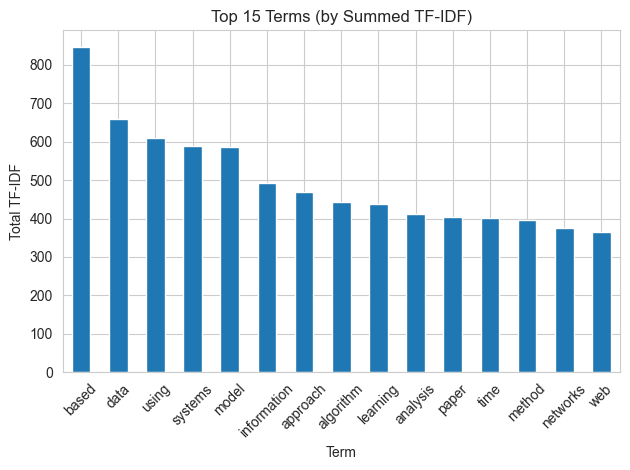

In [4]:
# ### Display top words visually:

plt.figure(figsize=(8, 5))
word_freq.head(15).plot.bar(x='word', y='freq', legend=False)
plt.title("Top 15 Terms (by Summed TF-IDF)")
plt.xlabel("Term")
plt.ylabel("Total TF-IDF")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [5]:
# ------------------------------------------------------------
# EXERCICE 3: Simple Search Engine (moteur de recherche)
# ------------------------------------------------------------
# Steps:
#   1) user query => vector
#   2) compare query vector with each doc vector (cosine similarity)
#   3) rank docs
#   4) display top documents
#
# Optionally test different weighting schemes, vocab sizes, etc.

# # EX3: Simple Search Engine
# We'll illustrate a basic approach using the same TF-IDF matrix.
# You can experiment with different vectorizers or similarity measures.

from sklearn.metrics.pairwise import cosine_similarity
from utils import search_engine

# Example usage:
query_example = "cat car beach"  # adapt as you like
results = search_engine(query_example, vectorizer, X, data, top_n=5)

for r in results:
    rank, score, title, abstract_text = r
    print(f"Rank {rank} - Score={score:.4f}")
    print("Title:", title)
    print("Abstract:", abstract_text[:200], "...")
    print("-" * 50)


Rank 1 - Score=0.5515
Title: Car-Parrinello Method
Abstract:  ...
--------------------------------------------------
Rank 2 - Score=0.4550
Title: A novel features design method for cat head detection
Abstract: In this paper we have proposed a new novel features model which designed to robustly detect the highly variable cat head patterns. Do not like human, cats usually have distinct different face, pose, a ...
--------------------------------------------------
Rank 3 - Score=0.4518
Title: CIAIR in-car speech database.
Abstract:  ...
--------------------------------------------------
Rank 4 - Score=0.4503
Title: PERFORMANCE MEASUREMENT OF CAR-TO-CAR AD-HOC NETWORKS IN THE REAL WORLD
Abstract:  ...
--------------------------------------------------
Rank 5 - Score=0.3609
Title: Speech recognition in the noisy car environment.
Abstract:  ...
--------------------------------------------------


First 10 documents with their assigned cluster:
                                               title  cluster_tfidf
0  Preliminary Design of a Network Protocol Learn...              1
1  A methodology for the physically accurate visu...              0
2  Comparison of GARCH, Neural Network and Suppor...              1
3  COMPARING GNG3D AND QUADRIC ERROR METRICS METH...              0
4  Improved Secret Image Sharing Method By Encodi...              4
5  A Self-Stabilizing Algorithm for Finding the C...              4
6  Fur Visualisation for Computer Game Engines an...              0
7  Multisymplectic Spectral Methods for the Gross...              2
8  Speech training systems using lateral shapes o...              4
9        Software Evolution through Transformations.              0


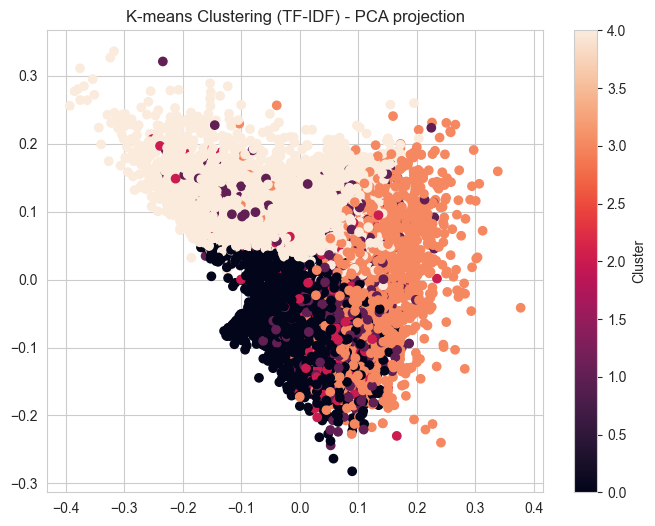

In [6]:
# ------------------------------------------------------------
# EXERCICE 4: Structurer le corpus (clustering, topics, doc2vec)
# ------------------------------------------------------------
# Approaches:
#   4.1 K-means on TF-IDF
#   4.2 LDA (topic modeling)
#   4.3 Doc2Vec + K-means

# # EX4: Clustering / Topic Modeling
#
# We illustrate:
# 1) **K-means in TF-IDF space**
# 2) **Topic modeling (LDA)**
# 3) **Doc2Vec + K-means**

# 4.1 K-Means in TF-IDF space
# -------------------------------------------------
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters_tfidf = kmeans.fit_predict(X)  # X is the TF-IDF matrix
data['cluster_tfidf'] = clusters_tfidf

print("First 10 documents with their assigned cluster:")
print(data[['title', 'cluster_tfidf']].head(10))

# Optional: PCA for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X.toarray())

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_tfidf)
plt.title("K-means Clustering (TF-IDF) - PCA projection")
plt.colorbar(label="Cluster")
plt.show()


In [7]:
from utils import preprocess_lemm
# 4.2 LDA (topic modeling) in Gensim
# -------------------------------------------------
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim import corpora
from gensim.models import LdaModel

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()



texts_lemm = data['text'].apply(preprocess_lemm).tolist()

dictionary_lemm = corpora.Dictionary(texts_lemm)
dictionary_lemm.filter_extremes(no_below=5, no_above=0.7)

corpus_lemm = [dictionary_lemm.doc2bow(tokens) for tokens in texts_lemm]

num_topics = 5
lda_model = LdaModel(
    corpus=corpus_lemm,
    num_topics=num_topics,
    id2word=dictionary_lemm,
    random_state=42,
    passes=10
)

print("Extracted topics (LDA):")
for topic_num, topic_words in lda_model.print_topics(num_words=5):
    print(f"Topic {topic_num} => {topic_words}")


# Assign dominant topic to each doc
def get_dominant_topic(bow):
    topics_probs = lda_model.get_document_topics(bow)
    if topics_probs:
        return max(topics_probs, key=lambda x: x[1])[0]
    return None


data['topic_lda'] = [get_dominant_topic(bow) for bow in corpus_lemm]
print("\nFirst few docs with their dominant LDA topic:")
print(data[['title', 'topic_lda']].head(10))


Extracted topics (LDA):
Topic 0 => 0.017*"system" + 0.011*"user" + 0.010*"information" + 0.008*"model" + 0.008*"process"
Topic 1 => 0.025*"algorithm" + 0.023*"problem" + 0.008*"method" + 0.008*"result" + 0.008*"time"
Topic 2 => 0.017*"method" + 0.017*"data" + 0.014*"image" + 0.013*"using" + 0.011*"model"
Topic 3 => 0.023*"network" + 0.020*"system" + 0.016*"data" + 0.010*"application" + 0.009*"performance"
Topic 4 => 0.016*"language" + 0.014*"model" + 0.013*"system" + 0.009*"knowledge" + 0.009*"approach"

First few docs with their dominant LDA topic:
                                               title  topic_lda
0  Preliminary Design of a Network Protocol Learn...          0
1  A methodology for the physically accurate visu...          0
2  Comparison of GARCH, Neural Network and Suppor...          2
3  COMPARING GNG3D AND QUADRIC ERROR METRICS METH...          1
4  Improved Secret Image Sharing Method By Encodi...          3
5  A Self-Stabilizing Algorithm for Finding the C...        

First few docs with cluster (Doc2Vec + K-means):
                                               title  cluster_d2v
0  Preliminary Design of a Network Protocol Learn...            1
1  A methodology for the physically accurate visu...            2
2  Comparison of GARCH, Neural Network and Suppor...            4
3  COMPARING GNG3D AND QUADRIC ERROR METRICS METH...            1
4  Improved Secret Image Sharing Method By Encodi...            1
5  A Self-Stabilizing Algorithm for Finding the C...            1
6  Fur Visualisation for Computer Game Engines an...            1
7  Multisymplectic Spectral Methods for the Gross...            1
8  Speech training systems using lateral shapes o...            4
9        Software Evolution through Transformations.            1


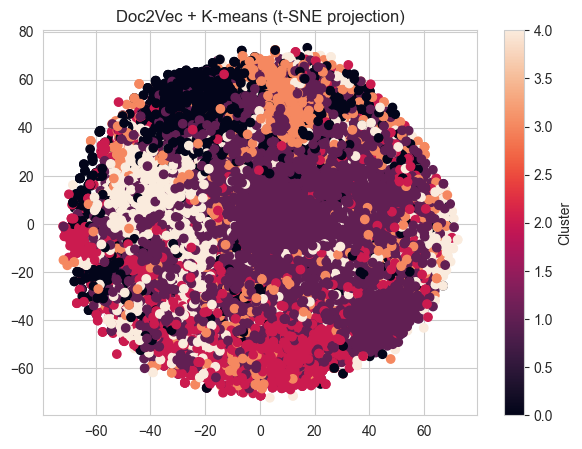

In [8]:
# 4.3 Doc2Vec + K-means
# -------------------------------------------------
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import numpy as np


def tokenize(text):
    return word_tokenize(text.lower())


documents = [TaggedDocument(words=tokenize(doc), tags=[i]) for i, doc in enumerate(data['text'])]
d2v_model = Doc2Vec(documents, vector_size=100, window=5, min_count=5, workers=4, epochs=40, seed=42)

doc_vectors = np.array([d2v_model.dv[i] for i in range(len(documents))])

kmeans_d2v = KMeans(n_clusters=n_clusters, random_state=42)
clusters_d2v = kmeans_d2v.fit_predict(doc_vectors)
data['cluster_d2v'] = clusters_d2v

print("First few docs with cluster (Doc2Vec + K-means):")
print(data[['title', 'cluster_d2v']].head(10))

# Optional: t-SNE for visualization
from sklearn.manifold import TSNE

X_2d = TSNE(n_components=2, random_state=42).fit_transform(doc_vectors)

plt.figure(figsize=(7, 5))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=clusters_d2v)
plt.title("Doc2Vec + K-means (t-SNE projection)")
plt.colorbar(label="Cluster")
plt.show()


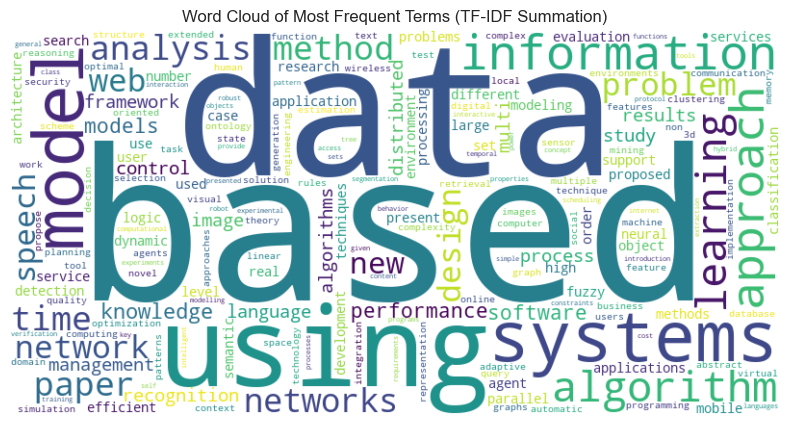

In [9]:
# ------------------------------------------------------------
# EXERCICE 5: Visualizations
# ------------------------------------------------------------
#   - Word cloud
#   - Most frequent bigrams
#   - Topic distributions
#   - etc.

# # EX5: Visualizations

# 5.1 Word Cloud from the aggregated TF-IDF frequencies
from wordcloud import WordCloud

freq_dict = dict(zip(word_freq['word'], word_freq['freq']))

wordcloud = WordCloud(width=800, height=400, background_color='white')
wordcloud.generate_from_frequencies(freq_dict)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Most Frequent Terms (TF-IDF Summation)")
plt.show()


Top 15 bigrams in the corpus:
                     bigram  freq
18344        paper presents  1227
21638             real time  1139
9257   experimental results  1041
18348         paper propose  1023
18341         paper present   888
21646            real world   769
20864       proposed method   699
25165             state art   682
16877        neural network   671
18242       paper describes   617
3962             case study   600
16878       neural networks   581
12533   information systems   579
25057    speech recognition   572
13521           large scale   557


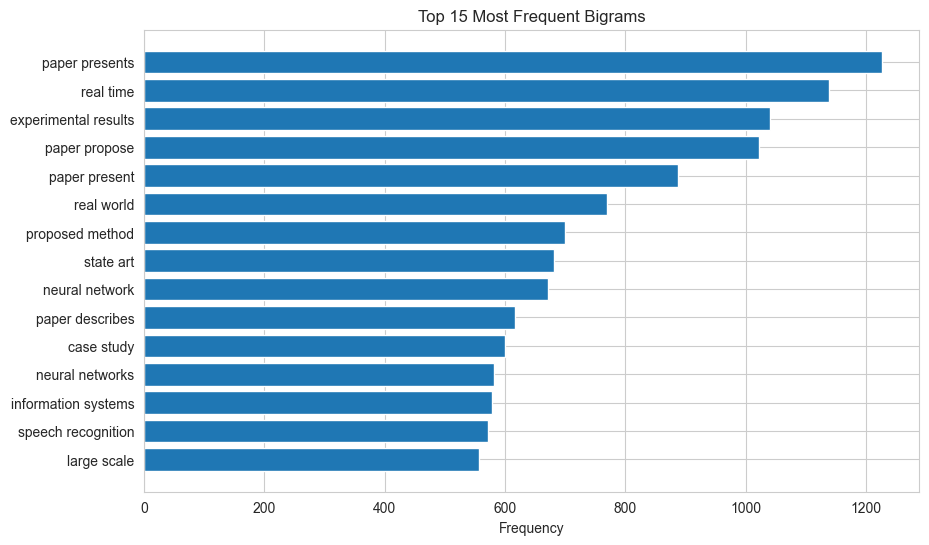

In [10]:
# 5.2 Bigrams (co-occurrences) with CountVectorizer(n-gram_range=(2,2))
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_bigrams = CountVectorizer(
    stop_words='english',
    ngram_range=(2, 2),
    min_df=5
)
X_bigrams = vectorizer_bigrams.fit_transform(data['text'])
sum_bigrams = X_bigrams.sum(axis=0).A1
bigram_vocab = vectorizer_bigrams.get_feature_names_out()

bigram_freq = pd.DataFrame({
    'bigram': bigram_vocab,
    'freq': sum_bigrams
}).sort_values(by='freq', ascending=False)

top_n = 15
top_bigrams = bigram_freq.head(top_n)

print(f"Top {top_n} bigrams in the corpus:")
print(top_bigrams)

plt.figure(figsize=(10, 6))
plt.barh(top_bigrams['bigram'][::-1], top_bigrams['freq'][::-1])
plt.xlabel("Frequency")
plt.title("Top 15 Most Frequent Bigrams")
plt.show()


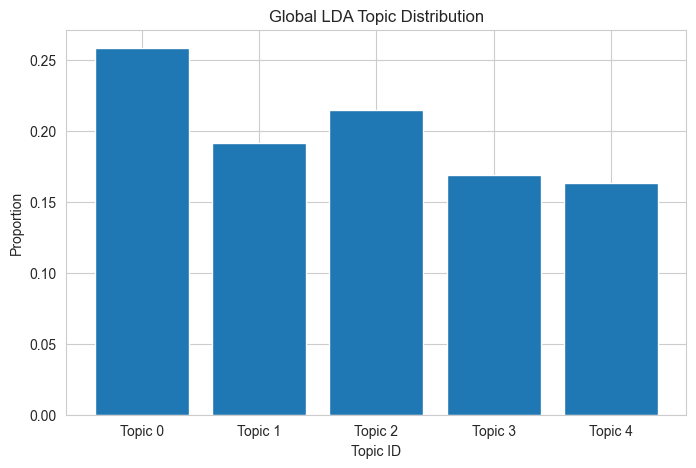

In [11]:
# 5.3 LDA Topic distribution across the corpus
doc_topics = [lda_model.get_document_topics(bow) for bow in corpus_lemm]
topic_proportions = np.zeros(num_topics)
for doc_dist in doc_topics:
    for (topic_id, prob) in doc_dist:
        topic_proportions[topic_id] += prob
topic_proportions /= len(doc_topics)

plt.figure(figsize=(8, 5))
plt.bar(range(num_topics), topic_proportions, tick_label=[f"Topic {i}" for i in range(num_topics)])
plt.title("Global LDA Topic Distribution")
plt.xlabel("Topic ID")
plt.ylabel("Proportion")
plt.show()


In [12]:
# ------------------------------------------------------------
# EXERCICE 6: Labeling Categories (Clusters/Topics)
# ------------------------------------------------------------
#   - For each cluster or topic, find top words
#   - Possibly find most central documents in clusters
#   - etc.

# # EX6: Labeling Categories
# **(Example)**: For each K-means cluster in TF-IDF space, we look for:
# - top words by aggregated TF-IDF
# - the most central documents (closest to cluster centroid)

# 6.1 Top words in each cluster
terms = vectorizer.get_feature_names_out()
X_array = X.toarray()

unique_clusters = sorted(data['cluster_tfidf'].unique())
top_words_by_cluster = {}

for c in unique_clusters:
    indices_c = np.where(data['cluster_tfidf'] == c)[0]
    cluster_tfidf_sum = X_array[indices_c].sum(axis=0)
    top_term_indices = np.argsort(cluster_tfidf_sum)[::-1]
    nb_top_words = 10
    top_indices = top_term_indices[:nb_top_words]
    top_terms = [(terms[idx], cluster_tfidf_sum[idx]) for idx in top_indices]
    top_words_by_cluster[c] = top_terms

print("=== Top words per cluster (TF-IDF) ===")
for c in unique_clusters:
    print(f"\nCluster {c}:")
    for (w, score) in top_words_by_cluster[c]:
        print(f"   {w} (sum={score:.2f})")

# 6.2 Most central documents (closest to cluster centroid) in TF-IDF space
centroids = kmeans.cluster_centers_
from sklearn.metrics.pairwise import euclidean_distances

most_central_docs = {}
for c in unique_clusters:
    indices_c = np.where(data['cluster_tfidf'] == c)[0]
    dists = euclidean_distances(X_array[indices_c], centroids[c].reshape(1, -1)).flatten()
    sorted_idx = np.argsort(dists)
    nb_docs_centrals = 3  # pick top 3
    best_idx = sorted_idx[:nb_docs_centrals]
    central_doc_indices = indices_c[best_idx]
    most_central_docs[c] = central_doc_indices

print("\n=== Most central documents per cluster ===")
for c in unique_clusters:
    doc_ids = most_central_docs[c]
    print(f"\nCluster {c}:")
    for did in doc_ids:
        doc_title = str(data.loc[did, 'title'])[:100]
        print(f" - Doc {did}, title: {doc_title}...")


=== Top words per cluster (TF-IDF) ===

Cluster 0:
   systems (sum=372.90)
   based (sum=299.70)
   information (sum=273.41)
   using (sum=239.67)
   networks (sum=227.45)
   software (sum=208.81)
   analysis (sum=208.23)
   knowledge (sum=205.29)
   management (sum=195.59)
   approach (sum=178.94)

Cluster 1:
   model (sum=410.25)
   design (sum=239.81)
   based (sum=96.66)
   systems (sum=68.92)
   models (sum=67.65)
   software (sum=56.23)
   process (sum=55.90)
   using (sum=55.35)
   language (sum=43.31)
   approach (sum=42.83)

Cluster 2:
   multi (sum=197.86)
   agent (sum=183.36)
   agents (sum=109.70)
   based (sum=42.89)
   systems (sum=40.03)
   mobile (sum=26.68)
   using (sum=22.22)
   approach (sum=22.19)
   learning (sum=21.91)
   model (sum=20.35)

Cluster 3:
   data (sum=460.08)
   web (sum=315.00)
   based (sum=86.04)
   mining (sum=79.43)
   information (sum=68.52)
   services (sum=64.61)
   semantic (sum=62.90)
   approach (sum=52.03)
   using (sum=51.41)
   applica

# TP3 GRAPHS

In [13]:
# ============================================================
# M2 MALIA-MIASHS: TP3
# Network Analysis for Information Retrieval (partie 3)
# 2024-2025
#
# EXERCISE 7 - Graph Analysis
# 7.1: Build adjacency matrix / graph
# 7.2: Graph statistics
# 7.3: Graph visualization
# 7.4: Graph-based clustering (spectral, Louvain, etc.)
# 7.5: Node2Vec or DeepWalk
# 7.6: Compare partitions with text-based categories
# ============================================================

# # 0) Setup
# We'll load the data that we've been working with in TP1 & TP2,
# then proceed with building and analyzing a graph structure.

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import ast

# For clustering
from sklearn.cluster import SpectralClustering
from sklearn.metrics import adjusted_rand_score  # For partition comparisons

# For Node2Vec
# pip install node 2 vec if you don't have it
from node2vec import Node2Vec

# Optional: if you want to try Louvain
# pip install python-louvain
# import community as community_louvain  # typical usage

# Some plotting settings
plt.rcParams["figure.figsize"] = (7, 5)

# Load your data.
print("Data en mémoire: Shape:", data.shape)
data.head(2)


Data en mémoire: Shape: (40596, 13)


/Users/antoinesirvent/miniconda3/envs/MasterMASTER/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,venue,abstract,authors,n_citation,references,title,year,id,class,text,cluster_tfidf,topic_lda,cluster_d2v
0,international conference on human-computer int...,The purpose of this study is to develop a lear...,"['Makoto Satoh', 'Ryo Muramatsu', 'Mizue Kayam...",0,"['51c7e02e-f5ed-431a-8cf5-f761f266d4be', '69b6...",Preliminary Design of a Network Protocol Learn...,2013,00127ee2-cb05-48ce-bc49-9de556b93346,3,The purpose of this study is to develop a lear...,1,0,1
1,visual analytics science and technology,This paper describes the design and implementa...,"['Gareth Beale', 'Graeme Earl']",50,"['10482dd3-4642-4193-842f-85f3b70fcf65', '3133...",A methodology for the physically accurate visu...,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821,3,This paper describes the design and implementa...,0,0,2


In [14]:
# # 7.1) Build the Graph
#
# We have multiple ways to define edges, e.g.:
# - Direct citation: If article A cites B, we create an edge A -> B.
# - Shared authors: If two articles share at least one author, we link them.
# - Same venue (journal/conference).
# - Common references, etc.
#
# Here, we'll illustrate a **direct citation** graph.
# You can adapt to your chosen method by collecting pairs of IDs that "match" your criteria.

# Build a directed graph from references
G = nx.DiGraph()

all_ids = set(data['id'])  # set of article IDs
G.add_nodes_from(all_ids)

# Suppose 'references' column is a list of IDs that the article cites.
# Make sure it's actually a Python list. If it's a string, we might need ast.literal_eval.
for idx, row in data.iterrows():
    source_id = row['id']
    refs_str = row.get('references', None)
    if pd.notnull(refs_str):
        # If references is stored as a stringified list, convert it:
        # references_list = ast.literal_eval(refs_str)
        # If it's already a list, use it directly.
        references_list = ast.literal_eval(refs_str) if isinstance(refs_str, str) else refs_str
        if not isinstance(references_list, list):
            continue

        for cited_id in references_list:
            # Only add edges for IDs present in our set
            if cited_id in all_ids:
                G.add_edge(source_id, cited_id)

print("Number of nodes in the graph:", G.number_of_nodes())
print("Number of edges in the graph:", G.number_of_edges())

# If you prefer an undirected graph (e.g., for shared authors), do:
# G = nx.Graph()


Number of nodes in the graph: 40596
Number of edges in the graph: 3641


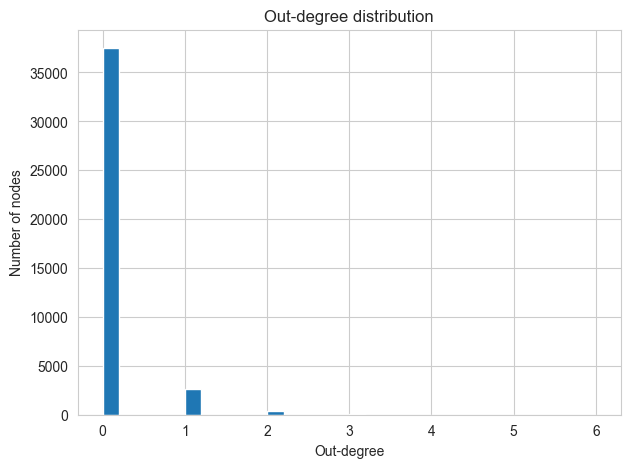

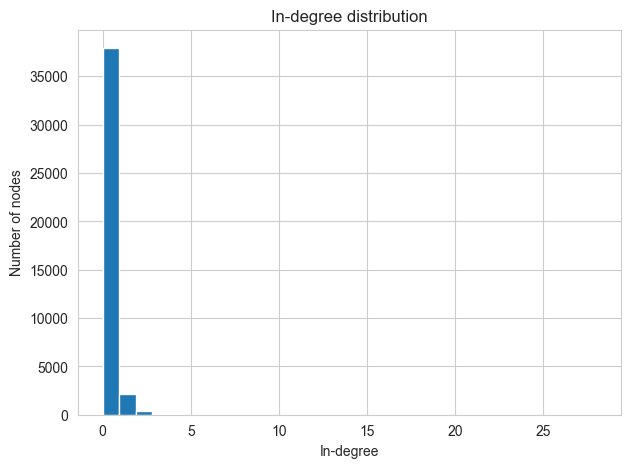

Density of the graph: 2.2093518727627886e-06
Number of strongly connected components: 40572
Largest SCC size: 2
Number of weakly connected components: 37117
Largest WCC size: 111
Diameter of largest WCC (undirected): 14
Average clustering (largest WCC, undirected): 0.03669273669273669


In [15]:
# # 7.2) Graph Statistics
#
# Examples:
# - Degree distribution (in/out-degree for directed graph)
# - Graph density
# - Clustering coefficient (convert to undirected, etc.)
# - Largest strongly (or weakly) connected component, diameter, etc.

# Degree stats
out_degs = dict(G.out_degree())
in_degs = dict(G.in_degree())

out_values = list(out_degs.values())
in_values = list(in_degs.values())

plt.hist(out_values, bins=30)
plt.title("Out-degree distribution")
plt.xlabel("Out-degree")
plt.ylabel("Number of nodes")
plt.show()

plt.hist(in_values, bins=30)
plt.title("In-degree distribution")
plt.xlabel("In-degree")
plt.ylabel("Number of nodes")
plt.show()

# Basic stats
density = nx.density(G)
print("Density of the graph:", density)

# For directed graphs, we often look at strongly connected components:
strongly_cc = list(nx.strongly_connected_components(G))
largest_scc = max(strongly_cc, key=len)
print("Number of strongly connected components:", len(strongly_cc))
print("Largest SCC size:", len(largest_scc))

# We can also look at weakly connected components (ignoring direction)
weakly_cc = list(nx.weakly_connected_components(G))
largest_wcc = max(weakly_cc, key=len)
print("Number of weakly connected components:", len(weakly_cc))
print("Largest WCC size:", len(largest_wcc))

# Diameter only makes sense on a connected subgraph
# We can subgraph the largest WCC or SCC, then convert to undirected if needed:
G_wcc = G.subgraph(largest_wcc).copy().to_undirected()
print("Diameter of largest WCC (undirected):", nx.diameter(G_wcc))

# Clustering coefficient typically on undirected graph:
clustering_coeff = nx.average_clustering(G_wcc)
print("Average clustering (largest WCC, undirected):", clustering_coeff)


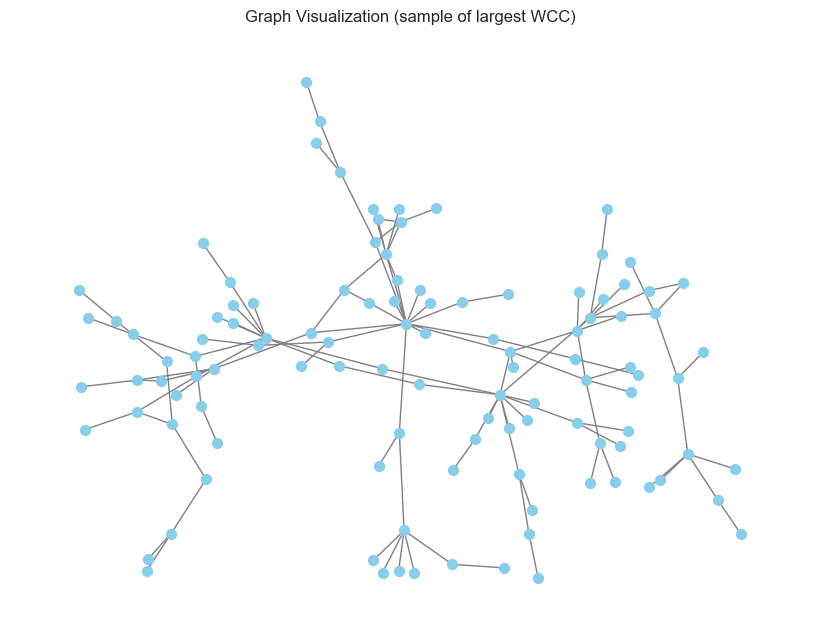

In [16]:
# # 7.3) Graph Visualization
#
# You can use many approaches: `networkx.draw`, `ipysigma`, `scikit-network`, etc.
# For small subgraphs, `networkx.draw` is fine. For large ones, consider specialized tools or sampling.

# Example: show a subgraph with a few nodes
# Let's just take the largest WCC if it's not too large, or sample some subset.

subgraph_size_limit = 2000  # max nodes we want to visualize
if len(largest_wcc) > subgraph_size_limit:
    # sample a portion of that wcc
    wcc_list = sorted(list(largest_wcc))
    subset_nodes = set(wcc_list[:subgraph_size_limit])  # first 2000
    G_vis = G.subgraph(subset_nodes).copy()
else:
    G_vis = G_wcc  # entire largest WCC

plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G_vis, k=0.15, seed=42)  # or another layout
nx.draw(G_vis, pos, node_size=50, node_color="skyblue", edge_color="gray", with_labels=False)
plt.title("Graph Visualization (sample of largest WCC)")
plt.show()

# Optionally color nodes by their LDA topic or cluster from previous TPs
# Example: color by data['topic_lda'][node].


In [17]:
# # 7.4) Graph-based Clustering
#
# Two classic approaches:
# 1. **Spectral Clustering** on the adjacency matrix or Laplacian matrix
# 2. **Community detection** (e.g., Louvain) for undirected graphs
#
# We'll show a quick example of spectral clustering on the largest WCC's adjacency.

# 7.4.1) Spectral Clustering example
sub_nodes = list(G_wcc.nodes())
sub_index = {n: i for i, n in enumerate(sub_nodes)}

A_sub = nx.to_numpy_array(G_wcc, nodelist=sub_nodes)  # adjacency matrix
n_clusters = 5

spectral = SpectralClustering(
    n_clusters=n_clusters,
    affinity='precomputed',  # we pass adjacency matrix
    assign_labels='kmeans',
    random_state=42
)
labels_spectral = spectral.fit_predict(A_sub)

# Create a mapping from node -> cluster
node2cluster_spectral = {}
for i, node_id in enumerate(sub_nodes):
    node2cluster_spectral[node_id] = labels_spectral[i]

# If you want, store it in your data. (Only if all or most IDs appear in data!)
data['cluster_spectral'] = data['id'].map(node2cluster_spectral).fillna(-1).astype(int)

data[['id', 'cluster_spectral']].head(10)


,id,cluster_spectral
0,00127ee2-cb05-48ce-bc49-9de556b93346,-1
1,001c58d3-26ad-46b3-ab3a-c1e557d16821,-1
2,001c8744-73c4-4b04-9364-22d31a10dbf1,-1
3,005ce28f-ed77-4e97-afdc-a296137186a1,-1
4,00701b05-684f-45f9-b281-425abfec482c,-1
5,00745041-3636-4d18-bbec-783c4278c40d,-1
6,00964544-cbe2-4da9-bb5a-03333160eb34,-1
7,00bcf2d5-1592-46b0-81fd-933f90b5ecca,-1
8,00ca027b-5174-40fa-bf63-9a97c2a5f518,-1
9,00dc2bba-3237-4d4e-b541-1205b97df981,-1


In [18]:
# # 7.5) Node2Vec or DeepWalk
#
# We can learn node embeddings from the graph alone, ignoring text content.
# We'll illustrate with **Node2Vec** from the `node2vec` library.

node2vec = Node2Vec(
    G_wcc,  # pass the largest WCC subgraph
    dimensions=64,
    walk_length=30,
    num_walks=200,
    workers=4,
    seed=42
)

model_n2v = node2vec.fit(
    window=10,
    min_count=1,
    batch_words=4
)

print("Node2Vec model trained!")

# Extract embeddings for each node in G_wcc
embeddings = {}
for node in G_wcc.nodes():
    embeddings[node] = model_n2v.wv[str(node)]  # keys are strings

# Turn embeddings into a matrix for subsequent analysis (clustering, visualization, etc.)
import numpy as np

node_list = list(G_wcc.nodes())
X_emb = np.array([embeddings[n] for n in node_list])

print("Node embeddings shape:", X_emb.shape)


Generating walks (CPU: 2): 100%|██████████| 50/50 [00:00<00:00, 247.96it/s]


Node2Vec model trained!
Node embeddings shape: (111, 64)


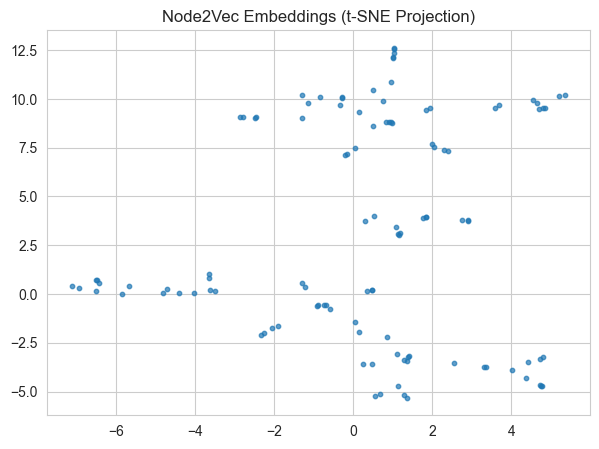

In [19]:
# Example: Visualize these node embeddings in 2D with t-SNE
from sklearn.manifold import TSNE

X_emb_2d = TSNE(n_components=2, random_state=42).fit_transform(X_emb)

plt.figure(figsize=(7, 5))
plt.scatter(X_emb_2d[:, 0], X_emb_2d[:, 1], s=10, alpha=0.7)
plt.title("Node2Vec Embeddings (t-SNE Projection)")
plt.show()

# You can color by cluster if you have them


In [20]:
# # 7.6) Compare partition from graph clustering with text-based categories
#
# From previous TPs, you might have a column like `topic_lda` or `cluster_tfidf`.
# We can compare it to the new graph-based partition (e.g., `cluster_spectral`)
# using a measure like Adjusted Rand Index (ARI).

# Suppose you have:
#   data['topic_lda']    -> integer topic label from LDA
#   data['cluster_spectral'] -> from spectral clustering
#
# We'll filter rows that have valid spectral cluster labels (which might be -1 if not in subgraph),
# and valid LDA topic labels.

df_compare = data[
    (data['cluster_tfidf'] != -1) &
    (~data['topic_lda'].isna())
    ].copy()

labels_text = df_compare['topic_lda'].astype(int)
labels_graph = df_compare['cluster_tfidf'].astype(int)

ari = adjusted_rand_score(labels_text, labels_graph)
print("Adjusted Rand Index (topic_lda vs. cluster_spectral):", ari)

# You can do the same with cluster_tfidf or cluster_d2v or LDA


Adjusted Rand Index (topic_lda vs. cluster_spectral): 0.061269343705092245


# TP4 pour aller plus loin

In [21]:
# ============================================================
# EXERCICE 8.1: Classification supervisée
# ============================================================
# Dans cet exercice, nous allons entraîner un modèle supervisé
# pour prédire la colonne "class" qui indique la catégorie
# de l'article (1=AI, 2=Data Science, 3=Interface, etc.).
# ------------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [22]:
# 1) Inspection de la colonne 'class'
# -----------------------------------
# Nous vérifions qu'elle contient bien des entiers entre 1 et 8,
# et regardons la distribution des classes.

print("Aperçu des valeurs de la colonne 'class':")
print(data['class'].value_counts())

# Si la colonne n'existe pas ou a un autre nom, adaptez ici.


Aperçu des valeurs de la colonne 'class':
class
1    10099
2     7388
5     5223
8     4812
7     4713
6     3570
4     2500
3     2291
Name: count, dtype: int64


In [23]:
# 2) Construction de la matrice de features pour la classification
# ----------------------------------------------------------------
# Approche textuelle : réutiliser la colonne 'text' (déjà abstract + title).
# Option A: réutiliser 'X' (TF-IDF complet) déjà construit + couplage data['class']
# Option B: reconvertir le texte en TF-IDF, éventuellement avec d'autres paramètres.
#
# Ci-dessous, on recalcule un TF-IDF simple. Si vous préférez réutiliser X existant,
# commentez cette cellule et passez directement à la 3).

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_clf = TfidfVectorizer(
    stop_words='english',
    max_df=0.85,
    min_df=5,
    lowercase=True
)

X_clf = tfidf_clf.fit_transform(data['text'])
y = data['class']  # la variable cible

print("X_clf shape (n_docs x n_terms):", X_clf.shape)
print("y shape:", y.shape)


X_clf shape (n_docs x n_terms): (40596, 13769)
y shape: (40596,)


In [24]:
# 3) Séparation Train / Test
# --------------------------
# Nous allons entraîner sur une fraction du corpus
# et tester sur le reste.

X_train, X_test, y_train, y_test = train_test_split(
    X_clf, y,
    test_size=0.2,  # 20% pour le test
    random_state=4,
    stratify=y  # preserve class distribution
)

print("Train size:", X_train.shape[0], "Test size:", X_test.shape[0])


Train size: 32476 Test size: 8120


In [25]:
# 4) Entraînement d'un classifieur (ex: LogisticRegression)
# --------------------------------------------------------
# On peut choisir n'importe quel algorithme scikit-learn :
# LogisticRegression, RandomForestClassifier, SVC, etc.
#
# Ici on fait simple, en montrant LogisticRegression.

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(
    max_iter=1000,  # on augmente pour être sûr de converger
    random_state=4
)
clf.fit(X_train, y_train)

print("Modèle entraîné !")


Modèle entraîné !


=== Classification Report ===
              precision    recall  f1-score   support

           1       0.50      0.74      0.60      2020
           2       0.41      0.52      0.46      1478
           3       0.40      0.13      0.20       458
           4       0.41      0.24      0.30       500
           5       0.41      0.44      0.43      1045
           6       0.43      0.36      0.39       714
           7       0.33      0.19      0.24       943
           8       0.28      0.16      0.20       962

    accuracy                           0.43      8120
   macro avg       0.40      0.35      0.35      8120
weighted avg       0.41      0.43      0.40      8120

=== Confusion Matrix ===
[[1503  173    8   69   80   58   83   46]
 [ 318  774   20   23  134   38   77   94]
 [ 142  114   61   23   42   28   22   26]
 [ 174   58   10  120   64   21   29   24]
 [ 164  212   11    7  458   64   47   82]
 [ 182  107    7    7   63  255   47   46]
 [ 244  212   21   27  116   57  177

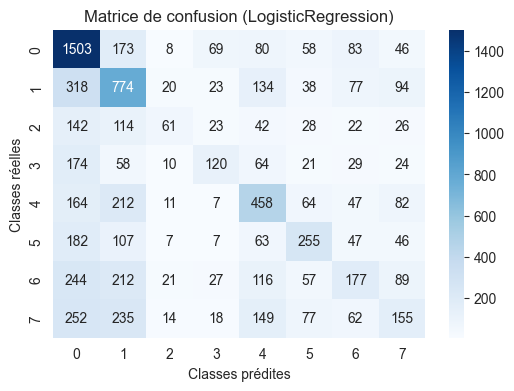

In [26]:
# 5) Évaluation sur le jeu de test
# --------------------------------
# On calcule les prédictions, puis on affiche un rapport
# de classification et la matrice de confusion.

y_pred = clf.predict(X_test)

print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
print("=== Confusion Matrix ===")
print(cm)

# Optionnel: visualisation graphique de la matrice de confusion
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matrice de confusion (LogisticRegression)")
plt.xlabel("Classes prédites")
plt.ylabel("Classes réelles")
plt.show()

